## Supervised Learning Final Project: AI Workforce Data 

The dataset I'm using for this was sourced from Kaggle. ai_job_market.csv contains data for AI related jobs like NLP Engineer, Quant Researcher, AI product manager, Data Scientist, and others. It also contains the required tech stack for each open position, seniority levels, salary ranges, and other relevant data.

### Goal
The plan is to explore salary predictions. there's enough data to train and evaluate a couple of models for that, but there's a lot of cleaning up needed first.


### EDA

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

df = pd.read_csv('ai_job_market.csv')

df.head()

,job_id,company_name,industry,job_title,skills_required,experience_level,employment_type,location,salary_range_usd,posted_date,company_size,tools_preferred
0,1,Foster and Sons,Healthcare,Data Analyst,"NumPy, Reinforcement Learning, PyTorch, Scikit...",Mid,Full-time,"Tracybury, AR",92860-109598,2025-08-20,Large,"KDB+, LangChain"
1,2,"Boyd, Myers and Ramirez",Tech,Computer Vision Engineer,"Scikit-learn, CUDA, SQL, Pandas",Senior,Full-time,"Lake Scott, CU",78523-144875,2024-03-22,Large,"FastAPI, KDB+, TensorFlow"
2,3,King Inc,Tech,Quant Researcher,"MLflow, FastAPI, Azure, PyTorch, SQL, GCP",Entry,Full-time,"East Paige, CM",124496-217204,2025-09-18,Large,"BigQuery, PyTorch, Scikit-learn"
3,4,"Cooper, Archer and Lynch",Tech,AI Product Manager,"Scikit-learn, C++, Pandas, LangChain, AWS, R",Mid,Full-time,"Perezview, FI",50908-123743,2024-05-08,Large,"TensorFlow, BigQuery, MLflow"
4,5,Hall LLC,Finance,Data Scientist,"Excel, Keras, SQL, Hugging Face",Senior,Contract,"North Desireeland, NE",98694-135413,2025-02-24,Large,"PyTorch, LangChain"


We've got some columns that can probably be dropped from here, job_id, posted_date, and a couple of other are not relevant to our goal, so we will clean them up before training.
It also looks like the skills_required column (which is probably the most useful one) actually contains sets of skills, so we'll need to extract that and build a dataset with each skill as an independent column. The same thing applies to tools_preferred.
salary_range_usd is not in a state we can use, but we can actually extract three properties from it: min_salary, avg_salary and max_salary.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   job_id            2000 non-null   int64 
 1   company_name      2000 non-null   object
 2   industry          2000 non-null   object
 3   job_title         2000 non-null   object
 4   skills_required   2000 non-null   object
 5   experience_level  2000 non-null   object
 6   employment_type   2000 non-null   object
 7   location          2000 non-null   object
 8   salary_range_usd  2000 non-null   object
 9   posted_date       2000 non-null   object
 10  company_size      2000 non-null   object
 11  tools_preferred   2000 non-null   object
dtypes: int64(1), object(11)
memory usage: 187.6+ KB


Looks like there's no null values in the entire dataset.

In [3]:
titles = df["job_title"].unique()
print(f"Total job titles: {len(titles)}: {titles}")

title_counts = df["job_title"].value_counts()

print(f"Job opening counts by title:")
title_counts

Total job titles: 8: ['Data Analyst' 'Computer Vision Engineer' 'Quant Researcher'
 'AI Product Manager' 'Data Scientist' 'ML Engineer' 'NLP Engineer'
 'AI Researcher']
Job opening counts by title:


job_title
Data Analyst                271
NLP Engineer                265
AI Product Manager          258
Quant Researcher            251
ML Engineer                 250
Data Scientist              238
AI Researcher               237
Computer Vision Engineer    230
Name: count, dtype: int64

Text(0.5, 1.0, 'Class Distribution (%)')

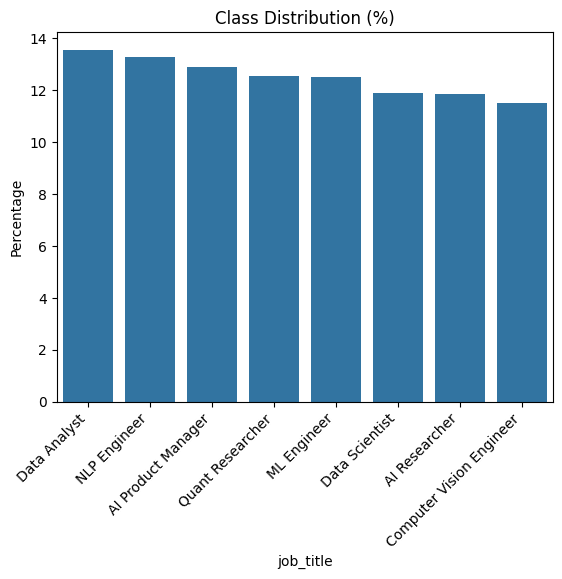

In [4]:
class_counts = df['job_title'].value_counts(normalize=True) * 100
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel('Percentage')
plt.title('Class Distribution (%)')

There's a bit of a class imbalance, Data Analyst has 41 more data points than Computer Vision Engineer and all the other positions have counts between these two. We can address this by using balanced class weights in scikit.

In [5]:
def parse_min_max_salary(salary_range):
    low,high = salary_range.split('-')
    return int(low.strip()),int(high.strip())

df[['min_salary', 'max_salary']] = df['salary_range_usd'].apply(lambda x: pd.Series(parse_min_max_salary(x)))

df['avg_salary'] = (df['min_salary'] + df['max_salary']) / 2


df[['min_salary', 'avg_salary', 'max_salary']]



,min_salary,avg_salary,max_salary
0,92860,101229.0,109598
1,78523,111699.0,144875
2,124496,170850.0,217204
3,50908,87325.5,123743
4,98694,117053.5,135413
...,...,...,...
1995,90382,100254.0,110126
1996,47848,92521.5,137195
1997,134994,157551.0,180108
1998,62388,72463.5,82539


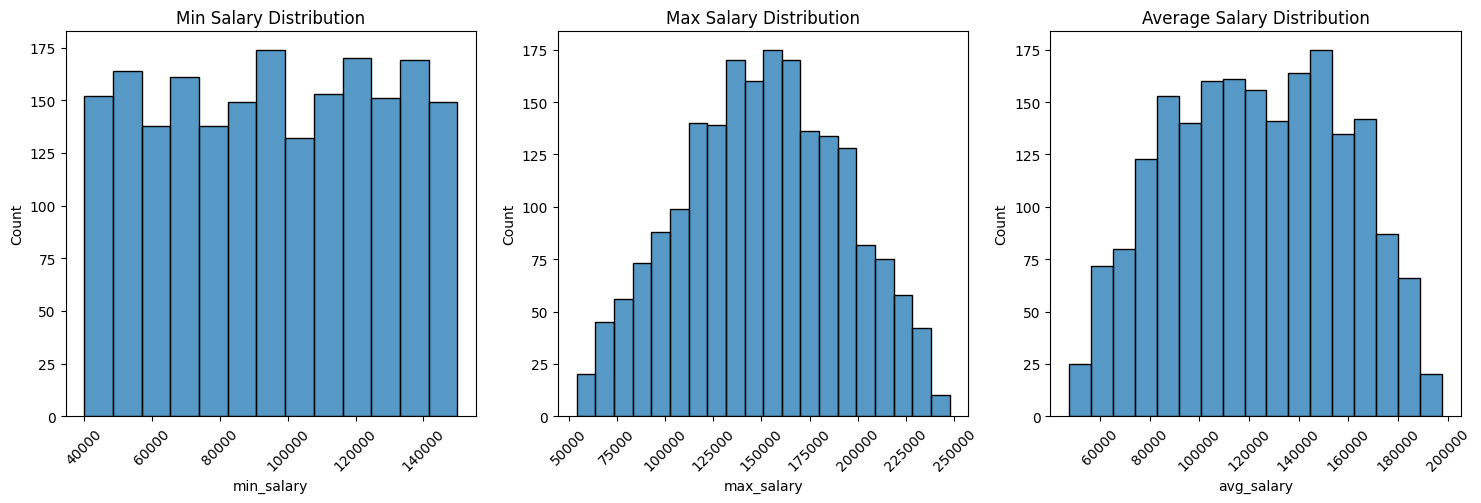

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['min_salary'], ax=ax[0])
ax[0].set_title("Min Salary Distribution")
ax[0].tick_params(axis='x', rotation=45)

sns.histplot(df['max_salary'], ax=ax[1])
ax[1].set_title("Max Salary Distribution")
ax[1].tick_params(axis='x', rotation=45)

sns.histplot(df['avg_salary'], ax=ax[2])
ax[2].set_title("Average Salary Distribution")
ax[2].tick_params(axis='x', rotation=45)
plt.show()

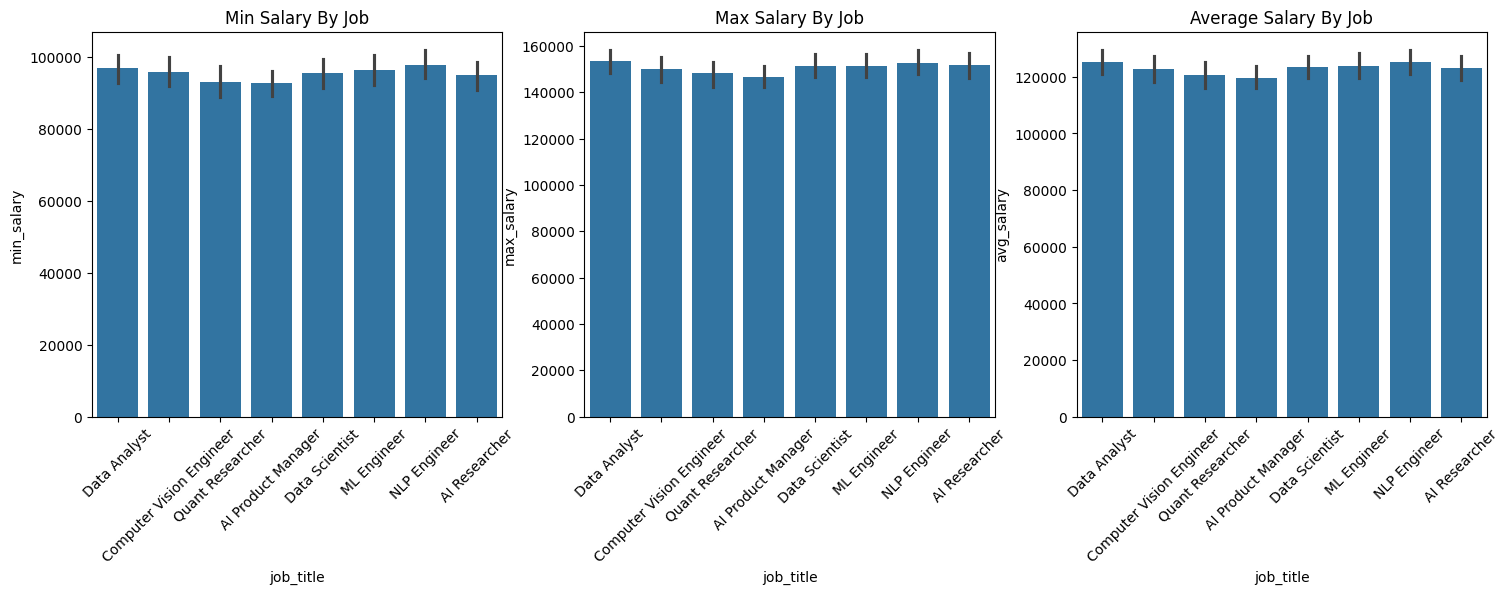

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=df, x='job_title', y='min_salary', ax=ax[0])
ax[0].set_title("Min Salary By Job")
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(data=df, x='job_title', y='max_salary', ax=ax[1])
ax[1].set_title("Max Salary By Job")
ax[1].tick_params(axis='x', rotation=45)

sns.barplot(data=df, x='job_title', y='avg_salary', ax=ax[2])
ax[2].set_title("Average Salary By Job")
ax[2].tick_params(axis='x', rotation=45)
plt.show()


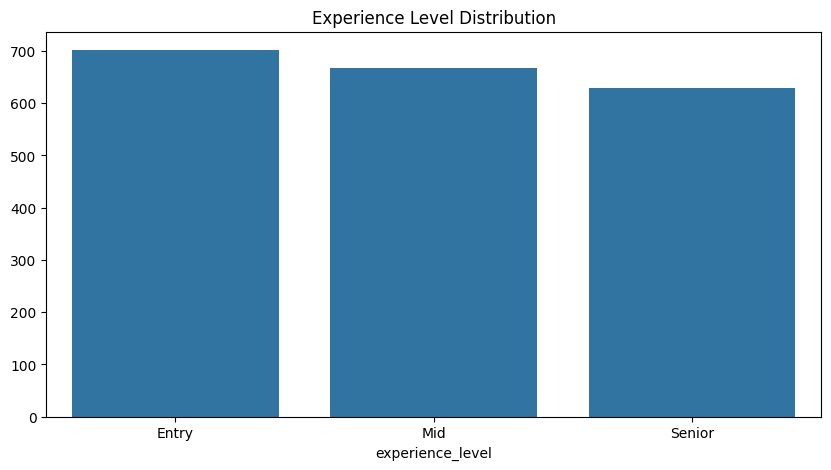

In [8]:
exp_counts = df['experience_level'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=exp_counts.index, y=exp_counts.values)
plt.title("Experience Level Distribution")
plt.show()

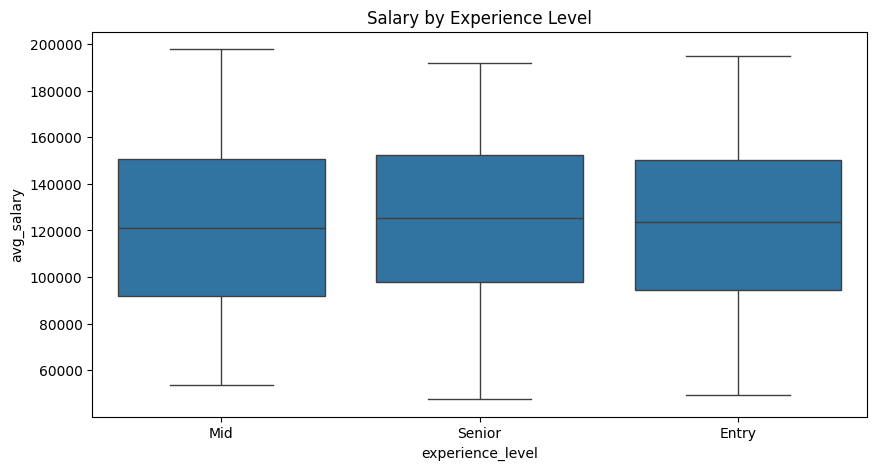

In [9]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='experience_level', y='avg_salary')
plt.title("Salary by Experience Level")
plt.show()

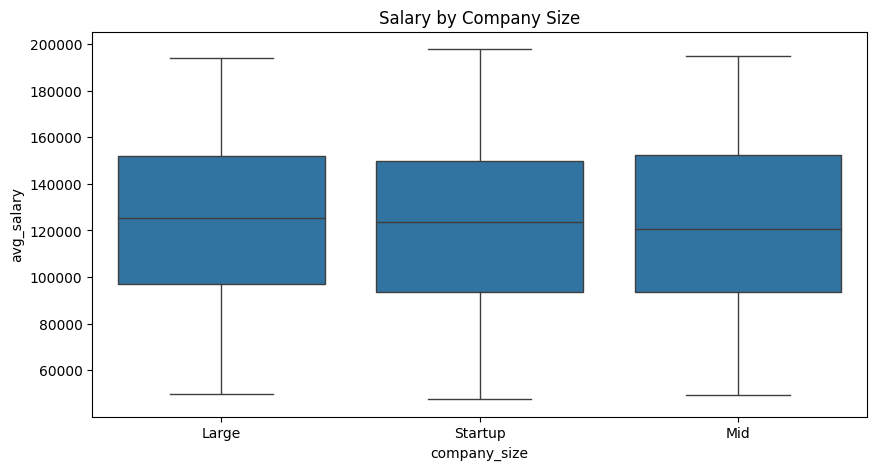

In [10]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='company_size', y='avg_salary')
plt.title("Salary by Company Size")
plt.show()

In [11]:
skills = df['skills_required'].str.split(", ")


all_skills = sorted({skill for lst in skills for skill in lst})
all_skills

print(f"Total skills: {len(all_skills)}\n{all_skills}")

Total skills: 22
['AWS', 'Azure', 'C++', 'CUDA', 'Excel', 'FastAPI', 'Flask', 'GCP', 'Hugging Face', 'Keras', 'LangChain', 'MLflow', 'NumPy', 'Pandas', 'Power BI', 'PyTorch', 'Python', 'R', 'Reinforcement Learning', 'SQL', 'Scikit-learn', 'TensorFlow']


In [12]:
tools = df['tools_preferred'].str.split(", ")
all_tools = sorted({tool for lst in tools for tool in lst})

print(f"Total tools: {len(all_tools)}\n{all_tools}")

Total tools: 8
['BigQuery', 'FastAPI', 'KDB+', 'LangChain', 'MLflow', 'PyTorch', 'Scikit-learn', 'TensorFlow']


In [13]:
for skill in all_skills:
    df[f"skill_{skill}"] = skills.apply(lambda lst: int(skill in lst))

for tool in all_tools:
    df[f"tool_{tool}"] = tools.apply(lambda lst: int(tool in lst))

df.head()

,job_id,company_name,industry,job_title,skills_required,experience_level,employment_type,location,salary_range_usd,posted_date,...,skill_Scikit-learn,skill_TensorFlow,tool_BigQuery,tool_FastAPI,tool_KDB+,tool_LangChain,tool_MLflow,tool_PyTorch,tool_Scikit-learn,tool_TensorFlow
0,1,Foster and Sons,Healthcare,Data Analyst,"NumPy, Reinforcement Learning, PyTorch, Scikit...",Mid,Full-time,"Tracybury, AR",92860-109598,2025-08-20,...,1,0,0,0,1,1,0,0,0,0
1,2,"Boyd, Myers and Ramirez",Tech,Computer Vision Engineer,"Scikit-learn, CUDA, SQL, Pandas",Senior,Full-time,"Lake Scott, CU",78523-144875,2024-03-22,...,1,0,0,1,1,0,0,0,0,1
2,3,King Inc,Tech,Quant Researcher,"MLflow, FastAPI, Azure, PyTorch, SQL, GCP",Entry,Full-time,"East Paige, CM",124496-217204,2025-09-18,...,0,0,1,0,0,0,0,1,1,0
3,4,"Cooper, Archer and Lynch",Tech,AI Product Manager,"Scikit-learn, C++, Pandas, LangChain, AWS, R",Mid,Full-time,"Perezview, FI",50908-123743,2024-05-08,...,1,0,1,0,0,0,1,0,0,1
4,5,Hall LLC,Finance,Data Scientist,"Excel, Keras, SQL, Hugging Face",Senior,Contract,"North Desireeland, NE",98694-135413,2025-02-24,...,0,0,0,0,0,1,0,1,0,0


### Put each skill and each tool in it's own column. 

The skills and tools data is not usable if we don't do this. Now for each data row, there's 1 in a skill if it's required and 0 otherwise. Same for tools.

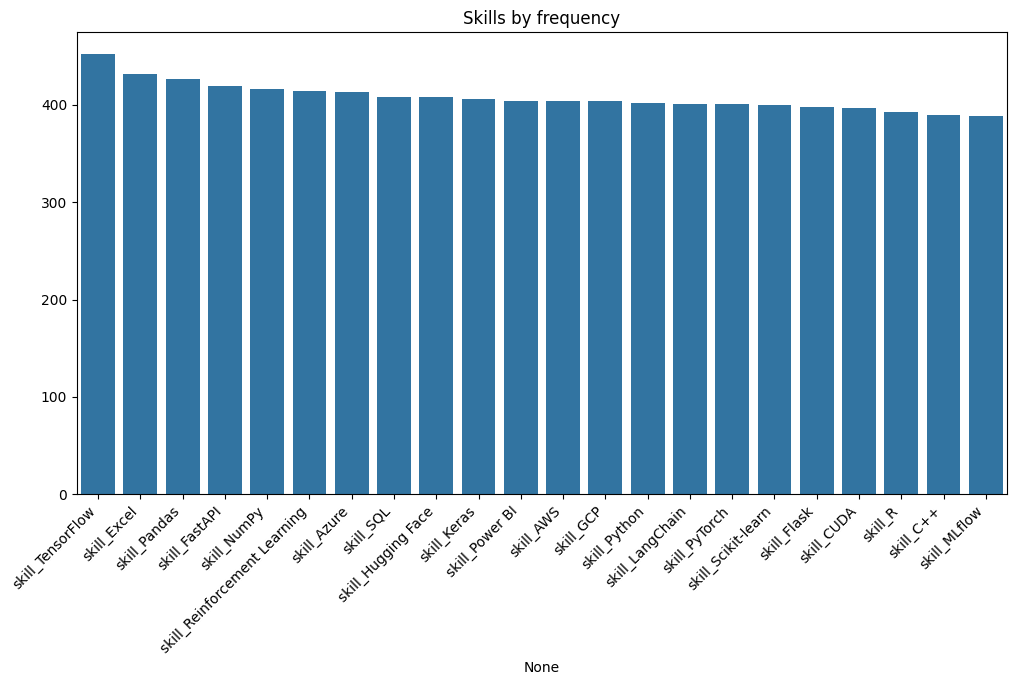

In [14]:
skill_cols = [col for col in df.columns if col.startswith("skill_")]
skill_freq = df[skill_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=skill_freq.index, y=skill_freq.values)
plt.xticks(rotation=45, ha="right")
plt.title("Skills by frequency")
plt.show()

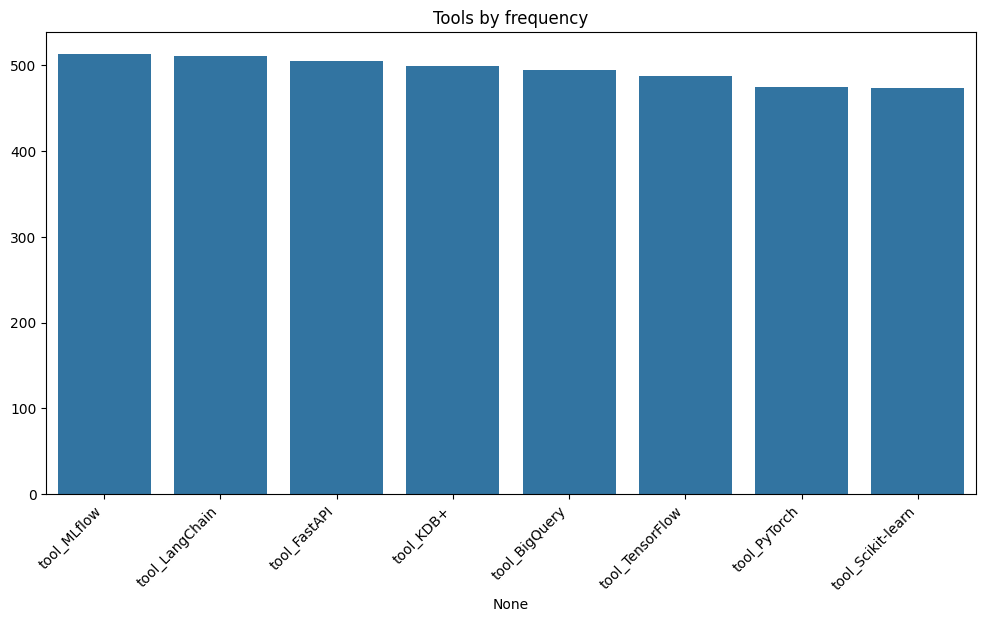

In [15]:
tool_cols = [col for col in df.columns if col.startswith("tool_")]
tool_freq = df[tool_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=tool_freq.index, y=tool_freq.values)
plt.xticks(rotation=45, ha="right")
plt.title("Tools by frequency")
plt.show()

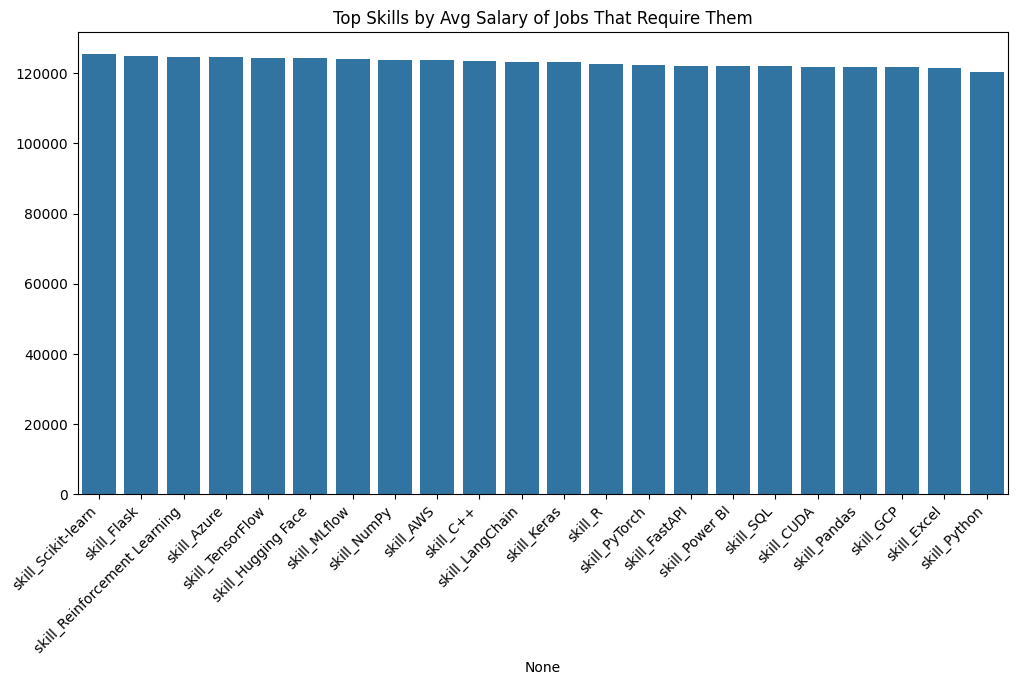

In [16]:
skill_salary_means = {
    skill: df[df[skill] == 1]['avg_salary'].mean()
    for skill in skill_cols
}

skill_salary_means = (
    pd.Series(skill_salary_means)
      .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(x=skill_salary_means.index, y=skill_salary_means.values)
plt.xticks(rotation=45, ha="right")
plt.title("Top Skills by Avg Salary of Jobs That Require Them")
plt.show()

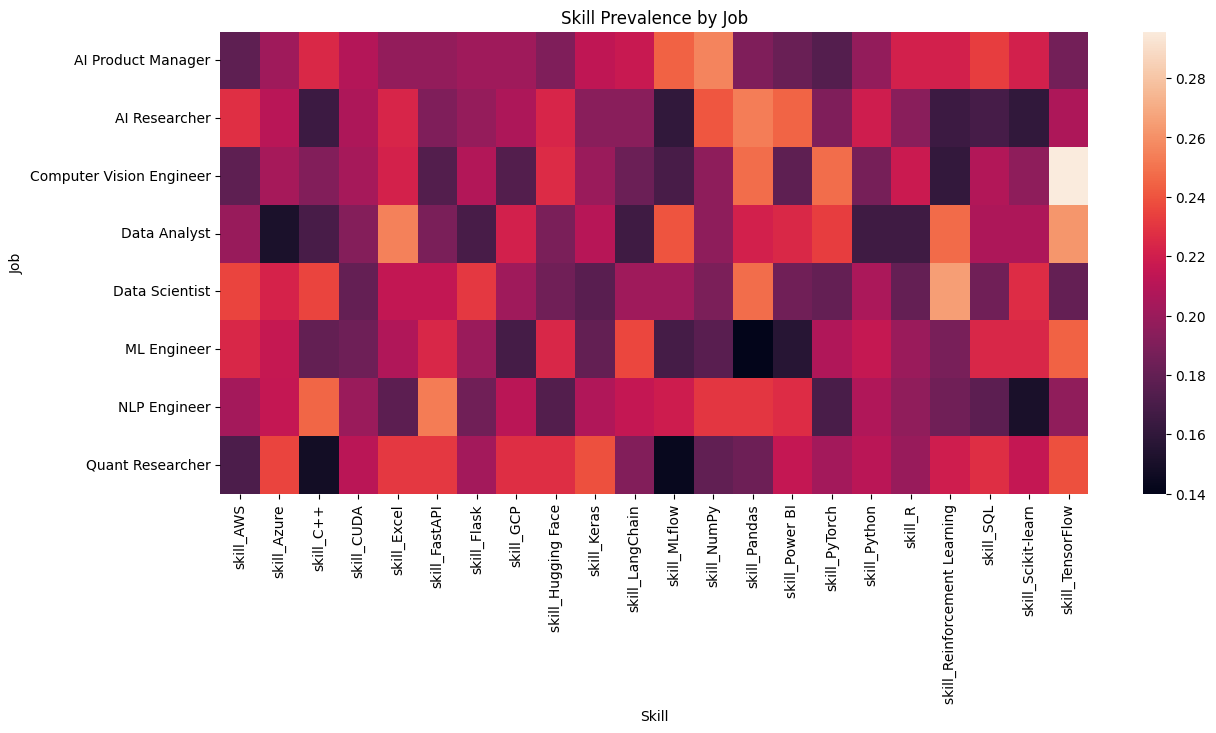

In [17]:
job_title_skill_matrix = df.groupby('job_title')[skill_cols].mean()

plt.figure(figsize=(14,6))
sns.heatmap(job_title_skill_matrix.sort_index())
plt.title("Skill Prevalence by Job")
plt.xlabel("Skill")
plt.ylabel("Job")
plt.show()

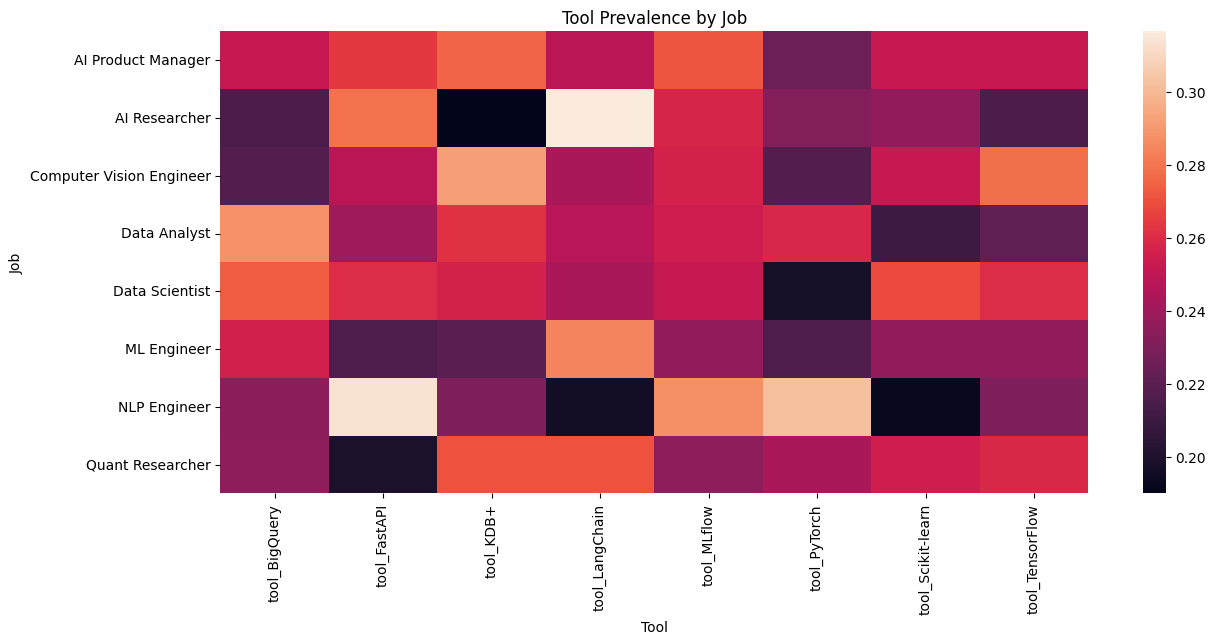

In [18]:
job_title_tool_matrix = df.groupby('job_title')[tool_cols].mean()

plt.figure(figsize=(14,6))
sns.heatmap(job_title_tool_matrix.sort_index())
plt.title("Tool Prevalence by Job")
plt.xlabel("Tool")
plt.ylabel("Job")
plt.show()

In [19]:
locations = sorted(df['location'].unique())

len(locations)


2000

It looks like location data is purely synthetic, all the locations are unique and most of the places don't really exist (Alexiston, UY is not a town in Uruguay, neither is Amyside, CH/Switzerland). We won't be using location as an input because of this. 
Each row has a unique location.


### Data Cleanup

We've already done some cleanup on the Skills needed and Tools by turning each cell from a single row to multiple columns with 0/1 encoding.

Another thing we cleaned up is the salary range, we took the X-Y string range and turned that into min, max, and avg salary. Since we will be training regression models, min and max salary will not encode any information that is not technically already represented by avg salary, so now that we are done with EDA, we can just clean up min and max.

We've also established that we won't be using Location, as there's a 1:1 row to location relationship and therefore unusable. From visual inspection it looks like the company column follows the same pattern so we'll be dropping that as well.

Finally, job_id is useless. It's a unique key for each row.

Now that salary, skills and tools are properly represented, we can delete the original columns.


In [20]:
cols_to_drop = [
    'skills_required',
    'tools_preferred',
    'job_id',
    'company_name',
    'location',
    'posted_date',
    'salary_range_usd',
    'min_salary',
    'max_salary'
]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

df.head()

,industry,job_title,experience_level,employment_type,company_size,avg_salary,skill_AWS,skill_Azure,skill_C++,skill_CUDA,...,skill_Scikit-learn,skill_TensorFlow,tool_BigQuery,tool_FastAPI,tool_KDB+,tool_LangChain,tool_MLflow,tool_PyTorch,tool_Scikit-learn,tool_TensorFlow
0,Healthcare,Data Analyst,Mid,Full-time,Large,101229.0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
1,Tech,Computer Vision Engineer,Senior,Full-time,Large,111699.0,0,0,0,1,...,1,0,0,1,1,0,0,0,0,1
2,Tech,Quant Researcher,Entry,Full-time,Large,170850.0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,0
3,Tech,AI Product Manager,Mid,Full-time,Large,87325.5,1,0,1,0,...,1,0,1,0,0,0,1,0,0,1
4,Finance,Data Scientist,Senior,Contract,Large,117053.5,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


Since we will be doing salary prediction, we can encode experience level numerically, same with company size. For industry, employment type and job title, we can do the same we did with skills and tools

In [21]:
all_exp = df['experience_level'].unique()

all_exp

array(['Mid', 'Senior', 'Entry'], dtype=object)

In [22]:
exp_mapping = {
    'Entry': 0,
    'Mid': 1,
    'Senior': 2
}
df['experience'] = df['experience_level'].map(exp_mapping)

In [23]:
all_company_sizes = df['company_size'].unique()
all_company_sizes

array(['Large', 'Startup', 'Mid'], dtype=object)

In [24]:
company_mapping = {
    'Startup': 0,
    'Mid': 1,
    'Large': 2
}

df['company'] = df['company_size'].map(company_mapping)

In [25]:
all_jobs = df['job_title'].unique()
all_jobs

array(['Data Analyst', 'Computer Vision Engineer', 'Quant Researcher',
       'AI Product Manager', 'Data Scientist', 'ML Engineer',
       'NLP Engineer', 'AI Researcher'], dtype=object)

In [26]:
for job in all_jobs:
    job_label = job.replace(" ","_")
    df[f"job_{job_label}"] = (df['job_title'] == job).astype(int)

In [27]:
all_industries = df['industry'].unique()
all_industries

array(['Healthcare', 'Tech', 'Finance', 'E-commerce', 'Automotive',
       'Education', 'Retail'], dtype=object)

In [28]:
for industry in all_industries:
    df[f"industry_{industry}"] = (df['industry'] == industry).astype(int)


In [29]:
all_employment_types = df['employment_type'].unique()
all_employment_types

array(['Full-time', 'Contract', 'Remote', 'Internship'], dtype=object)

In [30]:
for employment_type in all_employment_types:
    df[f"type_{employment_type}"] = (df['employment_type'] == employment_type).astype(int)


In [31]:
cols_to_drop = [
    'experience_level',
    'job_title',
    'industry',
    'employment_type',
    'company_size'
]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

df.head()

,avg_salary,skill_AWS,skill_Azure,skill_C++,skill_CUDA,skill_Excel,skill_FastAPI,skill_Flask,skill_GCP,skill_Hugging Face,...,industry_Tech,industry_Finance,industry_E-commerce,industry_Automotive,industry_Education,industry_Retail,type_Full-time,type_Contract,type_Remote,type_Internship
0,101229.0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,111699.0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,170850.0,0,1,0,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,87325.5,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,117053.5,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [39]:
# My regression was failing because of spaces in the columns, so I'm also cleaning that up as the
# last step here. Additionally, some column names contain '-', which could be interpreted wrong
# so I'll replace that with '_' too. Finally, C++ contains two pluses that break stuff, 
# I'll adress that too

for col in df.columns:
    new_name = col.replace(" ", "_").replace("-", "_").replace("+","p")
    rename_map[col] = new_name

print(rename_map)
df = df.rename(columns=rename_map)

df.head()

{'skill_C++': 'skill_Cpp', 'avg_salary': 'avg_salary', 'skill_AWS': 'skill_AWS', 'skill_Azure': 'skill_Azure', 'skill_CUDA': 'skill_CUDA', 'skill_Excel': 'skill_Excel', 'skill_FastAPI': 'skill_FastAPI', 'skill_Flask': 'skill_Flask', 'skill_GCP': 'skill_GCP', 'skill_Hugging_Face': 'skill_Hugging_Face', 'skill_Keras': 'skill_Keras', 'skill_LangChain': 'skill_LangChain', 'skill_MLflow': 'skill_MLflow', 'skill_NumPy': 'skill_NumPy', 'skill_Pandas': 'skill_Pandas', 'skill_Power_BI': 'skill_Power_BI', 'skill_PyTorch': 'skill_PyTorch', 'skill_Python': 'skill_Python', 'skill_R': 'skill_R', 'skill_Reinforcement_Learning': 'skill_Reinforcement_Learning', 'skill_SQL': 'skill_SQL', 'skill_Scikit_learn': 'skill_Scikit_learn', 'skill_TensorFlow': 'skill_TensorFlow', 'tool_BigQuery': 'tool_BigQuery', 'tool_FastAPI': 'tool_FastAPI', 'tool_KDB+': 'tool_KDBp', 'tool_LangChain': 'tool_LangChain', 'tool_MLflow': 'tool_MLflow', 'tool_PyTorch': 'tool_PyTorch', 'tool_Scikit_learn': 'tool_Scikit_learn', 'tool

,avg_salary,skill_AWS,skill_Azure,skill_Cpp,skill_CUDA,skill_Excel,skill_FastAPI,skill_Flask,skill_GCP,skill_Hugging_Face,...,industry_Tech,industry_Finance,industry_E_commerce,industry_Automotive,industry_Education,industry_Retail,type_Full_time,type_Contract,type_Remote,type_Internship
0,101229.0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,111699.0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,170850.0,0,1,0,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,87325.5,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,117053.5,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


### Model Training

We will train a simple Linear Regression, just like on the first week of the course, and then compare it to a Random Forest Regressor.
These two models give us very different approaches at this problem.



In [40]:
import statsmodels.formula.api as smf

columns = []

for column in df.columns:
    if column=='avg_salary':
        continue
    columns.append(column)

formula = "avg_salary ~ "+ " + ".join(columns)
print(formula)
print("============")
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

avg_salary ~ skill_AWS + skill_Azure + skill_Cpp + skill_CUDA + skill_Excel + skill_FastAPI + skill_Flask + skill_GCP + skill_Hugging_Face + skill_Keras + skill_LangChain + skill_MLflow + skill_NumPy + skill_Pandas + skill_Power_BI + skill_PyTorch + skill_Python + skill_R + skill_Reinforcement_Learning + skill_SQL + skill_Scikit_learn + skill_TensorFlow + tool_BigQuery + tool_FastAPI + tool_KDBp + tool_LangChain + tool_MLflow + tool_PyTorch + tool_Scikit_learn + tool_TensorFlow + experience + company + job_Data_Analyst + job_Computer_Vision_Engineer + job_Quant_Researcher + job_AI_Product_Manager + job_Data_Scientist + job_ML_Engineer + job_NLP_Engineer + job_AI_Researcher + industry_Healthcare + industry_Tech + industry_Finance + industry_E_commerce + industry_Automotive + industry_Education + industry_Retail + type_Full_time + type_Contract + type_Remote + type_Internship
                            OLS Regression Results                            
Dep. Variable:             avg_sal

### Linear Regression result analysis

The results look pretty bad, R^2 so low means that the data is basically random noise, which makes sense since the dataset looks synthetic and not very carefully tailored.

We have added a significant amount of predictors, but that seems to have made things worse, not better, and we can tell this because of the very low Adjusted R^2.

I didn't even bother doing a train_test split on this because it's visible right now that there's nothing to fit, but we can do that for the random forest model.


### Random Forest Regressor

This model might work better with the high colinearity, but I really don't have high expectations because of how random everything in the dataset seems to be. I'll do a train / test split and evaluate. The test set will be 20% of all the data.

In [42]:
from sklearn.model_selection import train_test_split

y = df['avg_salary']
X = df.drop(columns=['avg_salary'], errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test,y_pred_rf)

print("performance metrics:")
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R^2:", r2)

performance metrics:
MAE: 30951.549745833334
RMSE: 36508.69528023021
R^2: -0.030437862205328514


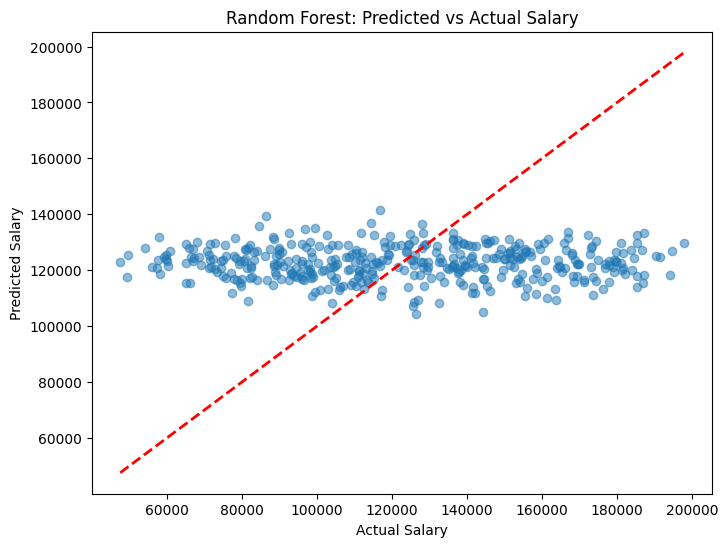

In [48]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Random Forest: Predicted vs Actual Salary")
plt.show()

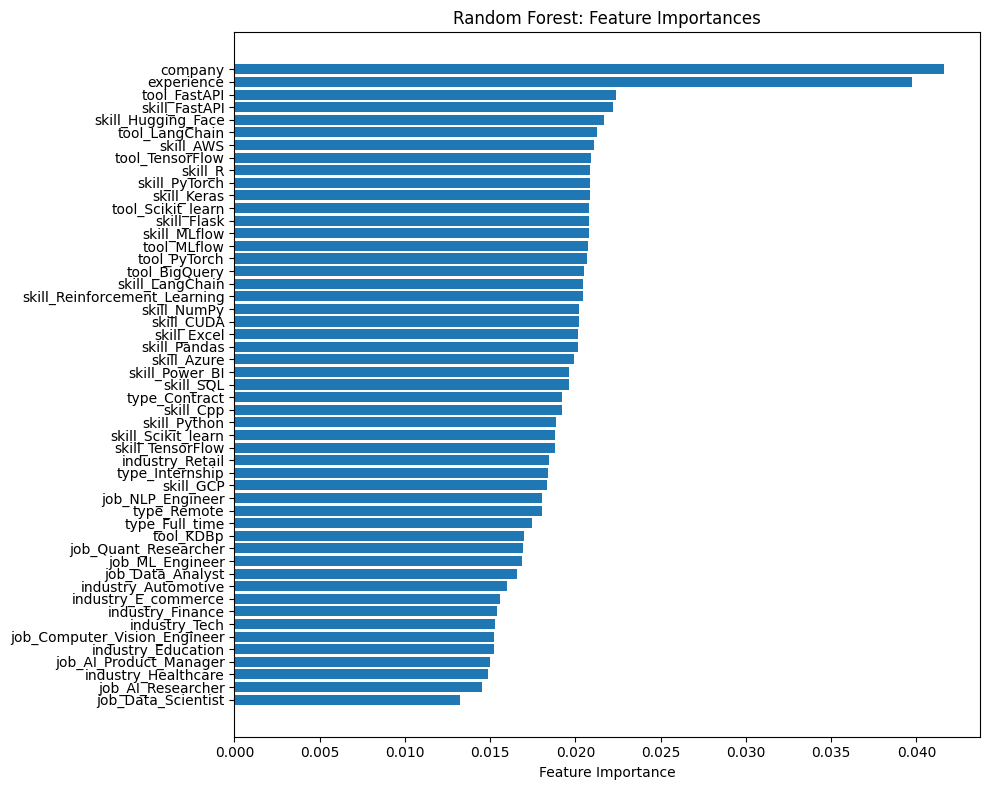

In [51]:
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X_train.columns[indices])
plt.xlabel("Feature Importance")
plt.title("Random Forest: Feature Importances")
plt.tight_layout()
plt.show()

### Random Forest Regressor result analysis

Mean absolute error: We are getting a 30k error on average, considering the salary ranges are between 100k and 150k, it means that there's pretty much no learning happening from this dataset.

Root mean squared error: Same thing, at about $36k it's suggesting the data is pure noise. RMSE penalizes large errors more than MAE.

R^2: It's negative, meaning there's nothing to learn from this dataset.

When looking at the predicte vs actual chart we can see that almost none of the predictions sit on the line

In terms of feature importance, only company and experience seem to matter a bit more, but on closer inspection it's because those two are not one-hot encoded, their importance is just as insignificant as the other features.



## Conclusions

From the EDA we could already tell that the synthetic data was not of very good quality, training two basic models confirmed that.

There's no point in even comparing both models because there's no performance to compare at all.

For the random forest regressor, we could easily see that tuning the number of jobs or estimators wouldn't have made any difference, and for the linear regression, removing features to try and get something more coherent wouldn't have worked either.

Overrall this was a great excercise for EDA and an interesting exploration of a dataset that is ultimately not useful for supervised learning, no matter which models and strategies we pick.


### References
- Submissions to previous modules for charts and model references
- Dataset: https://www.kaggle.com/datasets/minahilfatima12328/ai-workforce-data-overview
- The Deep Learning Book: Ian Goodfellow, Yoshua Bengio, Aaron Courville